<a href="https://colab.research.google.com/github/sharon-1234/Fmml/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-16 03:37:56--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.72, 13.225.4.109, 13.225.4.25, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   126MB/s    in 0.4s    

2024-05-16 03:37:56 (126 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


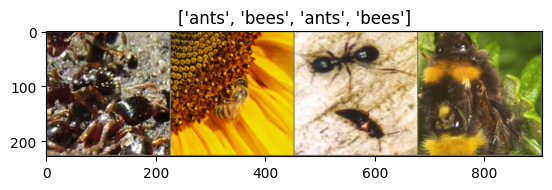

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.2MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6367 Acc: 0.6721

Epoch 1/4
----------
Loss: 0.6163 Acc: 0.7295

Epoch 2/4
----------
Loss: 0.5585 Acc: 0.7828

Epoch 3/4
----------
Loss: 0.4473 Acc: 0.7869

Epoch 4/4
----------


In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#ANSWERS:

1)ANSWER:-

Data augmentation techniques, such as resizing, cropping, flipping, rotation, and more, are crucial in training deep learning models, including Convolutional Neural Networks (CNNs), for several reasons:

1. **Increased Dataset Size**: Data augmentation effectively increases the effective size of the training dataset by generating new, slightly modified versions of existing images. This helps prevent overfitting by exposing the model to more diverse examples and variations of the same object or scene.

2. **Improved Generalization**: By presenting the model with augmented data during training, it learns to become more robust and invariant to various transformations that may occur in real-world scenarios. This improves the model's ability to generalize well to unseen data.

3. **Reduced Overfitting**: Data augmentation introduces variability into the training data, which can prevent the model from memorizing specific details of the training images and instead focus on learning more meaningful features. This reduces the risk of overfitting, where the model performs well on the training data but poorly on unseen data.

4. **Regularization**: Data augmentation acts as a form of regularization by adding noise to the training process. It helps to smooth the decision boundary and prevents the model from becoming overly sensitive to small variations in the input data, which can lead to improved generalization performance.

5. **Preservation of Spatial Invariance**: Techniques like resizing, cropping, and flipping preserve the spatial invariance properties of the model. For example, flipping an image horizontally or vertically does not change its semantic content but provides the model with additional variations of the same object or scene.

6. **Mitigation of Class Imbalance**: In classification tasks with imbalanced class distributions, data augmentation can be used to balance the class distribution by generating synthetic samples for minority classes. This ensures that the model receives sufficient training examples for each class, leading to better classification performance.

7. **Domain Adaptation**: Data augmentation techniques can help adapt the model to different domains or environments by simulating variations that are specific to the target domain. This is particularly useful in transfer learning scenarios where the model is pre-trained on a source domain and fine-tuned on a target domain.

Overall, data augmentation is a crucial component of training deep learning models, as it helps improve generalization, reduce overfitting, and enhance the model's robustness to various transformations and variations in the input data.

2)ANSWER:-

If you don't use a pre-trained ResNet model and train it from scratch on your dataset, the performance might be affected. Pre-training a model on a large dataset (like ImageNet) allows it to learn rich and generalizable features that can be transferred to other tasks. When you train a model from scratch, it needs to learn these features directly from your dataset, which might require more data and training time.

Here's a general outline of what might happen when you train a ResNet model from scratch:

1. **Training Time**: Training a deep neural network like ResNet from scratch typically requires more time and computational resources compared to fine-tuning a pre-trained model. Without pre-trained weights, the network starts with random initialization, and the weights need to be optimized from scratch during training.

2. **Data Requirements**: Deep neural networks usually require large amounts of data to learn meaningful representations directly from the data. If your dataset is small, training a ResNet model from scratch might lead to overfitting, where the model memorizes the training data without generalizing well to unseen data.

3. **Performance**: The performance of the model trained from scratch depends on various factors such as the size and quality of the dataset, the complexity of the task, the architecture of the network, and the optimization strategy. It's possible that the performance might not be as good as that of a pre-trained model, especially if your dataset is small or if the task is complex.

4. **Initialization**: Random initialization of the weights can sometimes lead to suboptimal solutions, especially in deep networks. While techniques like Xavier or He initialization help mitigate this issue, they might not be as effective as starting from pre-trained weights.

5. **Generalization**: Without pre-training, the model might struggle to generalize well to unseen data, especially if the dataset is significantly different from the data on which the model was trained. Pre-training helps the model learn generic features that are useful for a wide range of tasks.

In summary, training a ResNet model from scratch can still yield good performance, especially if you have a large and diverse dataset and sufficient computational resources. However, for many practical applications, fine-tuning a pre-trained ResNet model often provides better results in terms of both performance and efficiency.

3)ANSWER:-

The performance of a pre-trained ResNet model on a task like classifying ants vs. bees images can still be quite good, even if the pre-training dataset is significantly different from the target dataset. This is one of the key advantages of transfer learning.

Here's why using a pre-trained model can still lead to good performance:

1. **Transferability of Features**: Convolutional neural networks, especially deep ones like ResNet, learn hierarchical features that capture general visual patterns. Lower layers typically learn low-level features like edges and textures, while higher layers learn more abstract and complex features like object parts and shapes. Many of these features are generic and transferable across different visual recognition tasks, regardless of the specific dataset they were trained on.

2. **Fine-tuning**: While the pre-trained model has learned useful generic features, the final layers of the network (the fully connected layers) are task-specific. By fine-tuning the pre-trained model on the target dataset (ants vs. bees), you allow the model to adapt these task-specific layers to the new dataset, further improving performance. Fine-tuning involves updating the weights of the entire network using the new dataset while allowing the pre-trained weights to be adjusted based on the new data.

3. **Regularization**: Pre-trained models act as a form of regularization. By starting with weights that have been learned from a large dataset, you're effectively starting closer to a good solution. This can help prevent overfitting, especially when the target dataset is small.

4. **Feature Reuse**: Even if the pre-trained dataset is significantly different, many features learned by the pre-trained model are likely to be relevant to the new dataset. The lower layers of the network, which capture low-level features like edges and textures, are often shared across many visual recognition tasks. By using a pre-trained model, you can leverage these shared features and focus on learning the more dataset-specific features during fine-tuning.

While using a pre-trained model may not always lead to the best possible performance, it often provides a good starting point and can significantly reduce the amount of labeled data and computational resources required for training a model from scratch.